In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# d1 = {"s": 1,
#       "t" : 2}

# d2 = {"s1": 1,
#       "t1" : 2}

# d1 = {f"train/{key}": value for key, value in d1.items() }
# d1

In [3]:
import os
import torch
from hydra import initialize, compose
from hydra.utils import instantiate

os.environ["HYDRA_FULL_ERROR"] = "1"
os.environ["NUMBA_CACHE_DIR"] = "/tmp/"

with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name='config.yaml')
    
cfg.data.batch_size = 4

/usr/local/lib/python3.10/dist-packages/hydra/core/plugins.py:225: UserWarning: 
	Error importing 'hydra_plugins.hydra_colorlog'.
	Plugin is incompatible with this Hydra version or buggy.
	Recommended to uninstall or upgrade plugin.
		ImportError : cannot import name 'SearchPathPlugin' from 'hydra.plugins' (/usr/local/lib/python3.10/dist-packages/hydra/plugins/__init__.py)
  warnings.warn(


In [4]:
cfg

{'denoiser': {'_target_': 'dasr.models.facebook_denoiser.get_pretrained_model', 'name': 'dns64', 'freeze_encoder': True, 'freeze_lstm': False, 'freeze_decoder': False}, 'facebook_denoiser': {'segment': 4}, 'device': 'cuda', 'asr': {'_target_': 'dasr.asr.wav2vec.Wav2VecEnv', 'device': 'cuda', 'path_model': 'jonatasgrosman/wav2vec2-large-xlsr-53-russian', 'asr_metric': 'cer', 'loss_type': 'ctc'}, 'train': {'optimizer': {'_target_': 'torch.optim.Adam', 'learning_rate': 0.0003}, 'trainer': {'_target_': 'dasr.train.trainer.Trainer'}, 'n_epoch': 1000, 'use_asr_loss': True, 'use_geom_loss': True, 'n_epoch_before_asr_loss': 0, 'asr_loss_coef': 0.2}, 'loss': {'_target_': 'dasr.losses.loss_factory.AdditiveLoss', 'criteria': 'l1', 'use_sfft_loss': True, 'factor_sc': 0.5, 'factor_mag': 0.5}, 'wandb': {'_target_': 'dasr.logger.wandb_logger.WandbLogger', 'project_name': 'dasr', 'run_name': 'wav2vec+pretrained_dns64 [lr=3e-4] (freeze encoder), SNR=10, train[0:3000] CTC'}, 'data': {'_target_': 'dasr.t

In [5]:
import pytorch_lightning as pl
from dasr.train.pl_data import DASRDataModule
from dasr.train.pl_model import DASRModel

In [6]:
# dm = DASRDataModule(cfg)
# dm.setup("fit")

# loader = dm.val_dataloader()
# batch = next(iter(loader))
# batch

In [7]:
dm = DASRDataModule(cfg)
dasr = DASRModel(cfg)

loggers = [
    pl.loggers.WandbLogger(
        project=cfg.wandb.project_name,
        name=cfg.wandb.run_name,
    ),
]

Freezing encoder


In [8]:
trainer = pl.Trainer(accelerator="cuda", logger=loggers)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model=dasr, datamodule=dm)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: petili. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params
-------------------------------------------
0 | model     | Demucs       | 33.5 M
1 | geom_loss | AdditiveLoss | 0     
-------------------------------------------
25.2 M    Trainable params
8.4 M     Non-trainable params
33.5 M    Total params
134.134   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:632: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:801.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [24]:
train_loader, test_loader = instantiate(cfg.data)

Start loading datasets
Train dataset loaded
Test dataset loaded


In [33]:
sample = next(iter(test_loader))
sample.keys()

dict_keys(['clean_audios', 'noise_audios', 'clean_attention_masks', 'noise_attention_masks', 'transcriptions'])

In [60]:
clean_audio = sample["clean_audios"][0]
clean_audio = clean_audio[0:77000]


mask = sample["clean_attention_masks"][0]
n_non_masked = int(mask.sum())
clean_audio = clean_audio[:n_non_masked]

noise = torch.randn_like(clean_audio) * 0.004

noise_audio = clean_audio + noise

# noise_audio = sample["noise_audios"][0]



# noise_audio = noise_audio[:n_non_masked]

# noise =  clean_audio - noise_audio

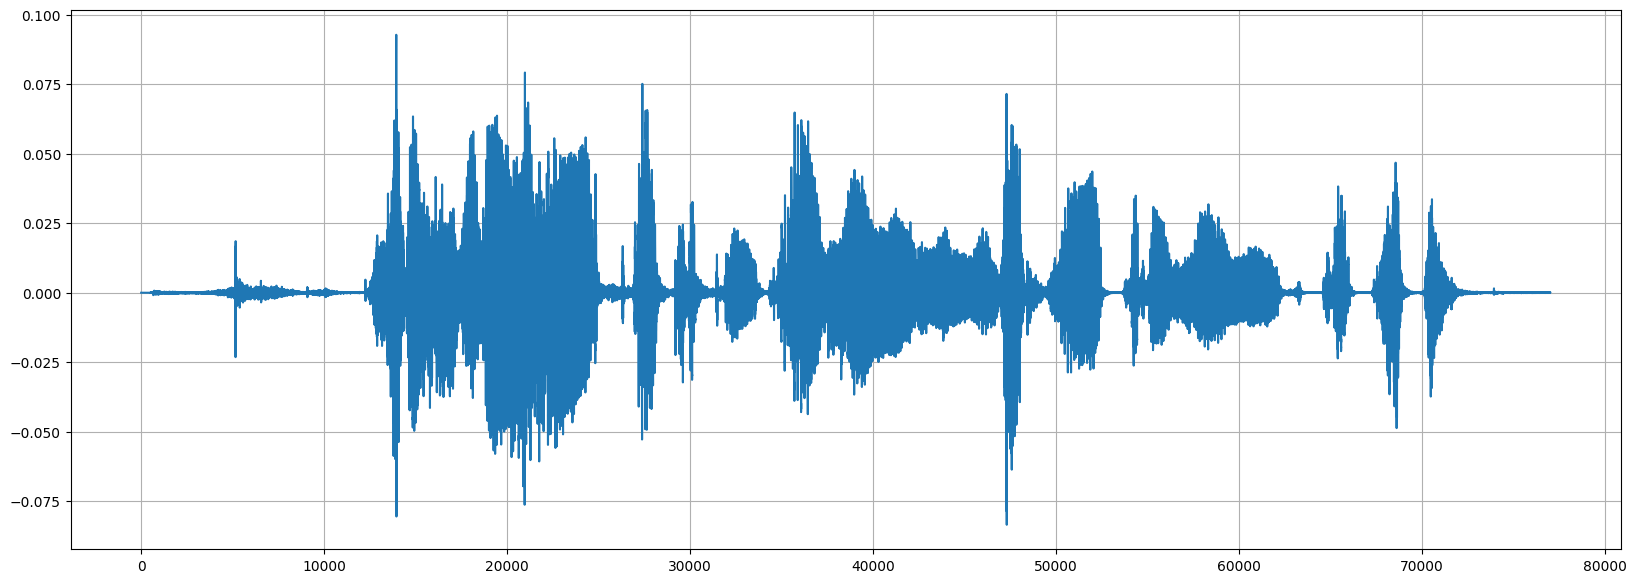

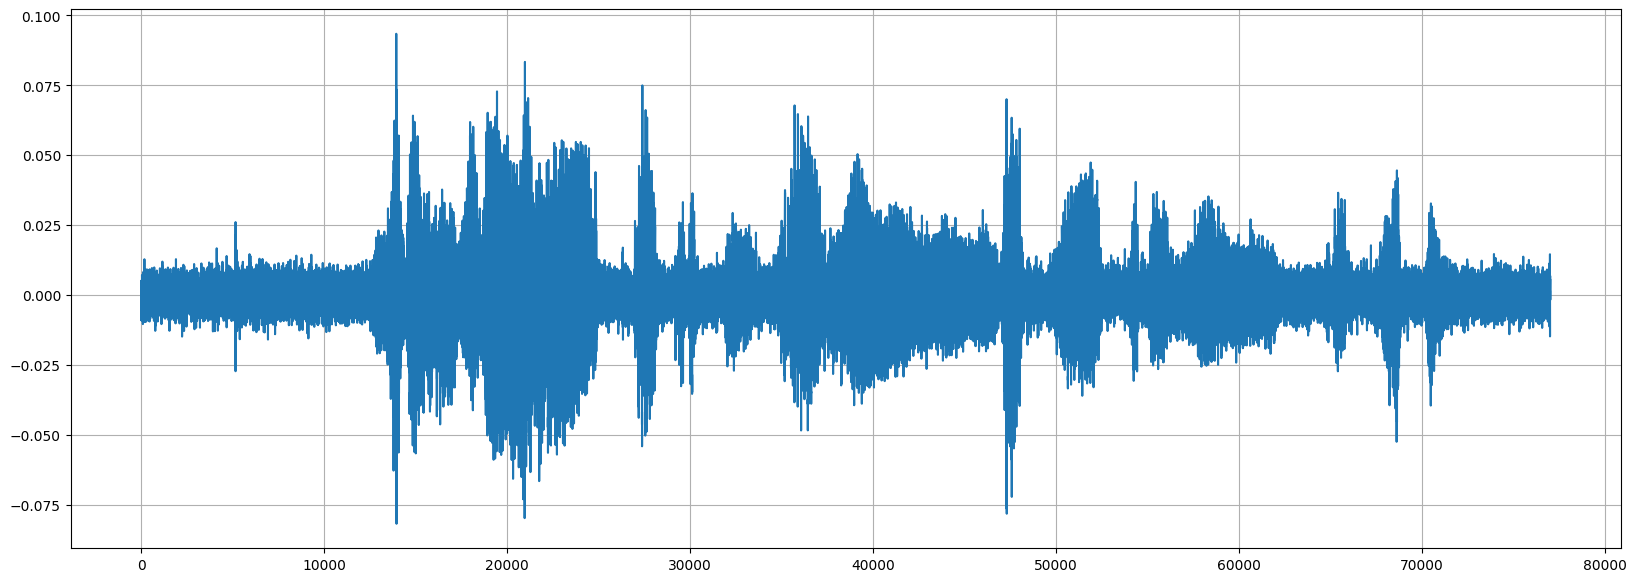

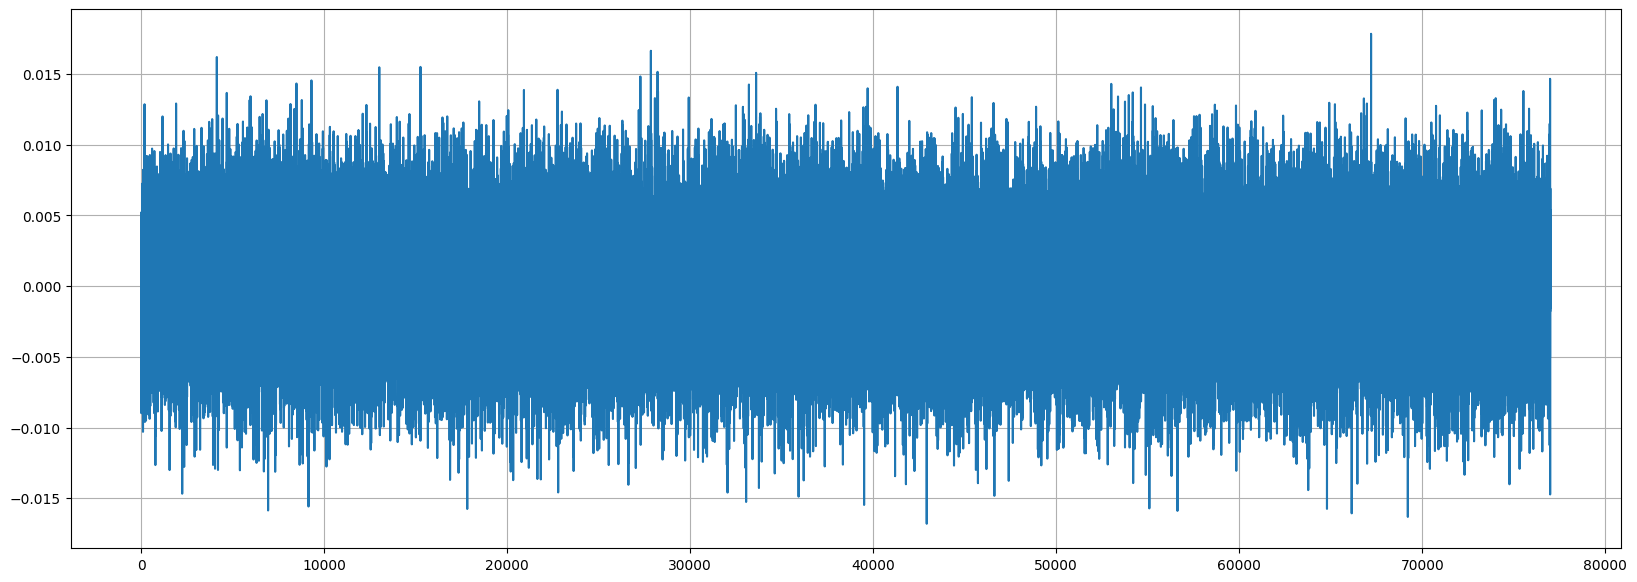

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))
plt.plot(clean_audio)
plt.grid()

plt.figure(figsize=(20, 7))
plt.plot(noise_audio)
plt.grid()

plt.figure(figsize=(20, 7))
plt.plot(noise)
plt.grid()

In [29]:
import re
from types import MethodType

import torch
import torch.nn.functional as F
from evaluate import load
from transformers import WhisperForConditionalGeneration, WhisperProcessor
from undecorated import undecorated

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from transformers import Wav2Vec2Config

In [2]:
def normalize_text(text: str):
    for char in [".", ",", "!", "?", "(", ")"]:
        text = text.replace(char, " ")
    text = text.replace("ё", "е")
    text = re.sub(" +", " ", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower().strip()
    return text

In [3]:
import os
from hydra import initialize, compose
from hydra.utils import instantiate

os.environ["HYDRA_FULL_ERROR"] = "1"
os.environ["NUMBA_CACHE_DIR"] = "/tmp/"

with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name='config.yaml')
    
cfg.data.batch_size = 4

/usr/local/lib/python3.10/dist-packages/hydra/core/plugins.py:225: UserWarning: 
	Error importing 'hydra_plugins.hydra_colorlog'.
	Plugin is incompatible with this Hydra version or buggy.
	Recommended to uninstall or upgrade plugin.
		ImportError : cannot import name 'SearchPathPlugin' from 'hydra.plugins' (/usr/local/lib/python3.10/dist-packages/hydra/plugins/__init__.py)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [30]:
path_model = "jonatasgrosman/wav2vec2-large-xlsr-53-russian"
processor = Wav2Vec2Processor.from_pretrained(path_model)

config = Wav2Vec2Config.from_pretrained(path_model)

In [4]:
train_loader, test_loader = instantiate(cfg.data)

Start loading datasets
Train dataset loaded
Test dataset loaded


In [6]:
transcriptions = []

for batch in train_loader:
    t = batch["transcriptions"]
    transcriptions.extend(t)

In [35]:
from collections import Counter
from pprint import pprint

lens = []

for t in transcriptions:
    t = normalize_text(t)

    target_ids = processor(text=t, padding=True, return_tensors="pt").input_ids

    lens.append(target_ids.shape[1])

length_counts = Counter(lens)
pprint(length_counts, sort_dicts=False)


Counter({19: 44,
         29: 42,
         32: 42,
         63: 41,
         37: 40,
         69: 39,
         53: 39,
         46: 39,
         55: 38,
         21: 37,
         66: 36,
         35: 36,
         50: 36,
         28: 36,
         83: 36,
         20: 36,
         30: 36,
         26: 36,
         51: 35,
         41: 35,
         75: 35,
         56: 34,
         79: 34,
         77: 34,
         24: 34,
         88: 33,
         48: 33,
         70: 33,
         74: 33,
         60: 33,
         65: 33,
         22: 32,
         52: 32,
         64: 32,
         71: 32,
         58: 32,
         80: 31,
         33: 31,
         18: 31,
         54: 31,
         57: 31,
         59: 31,
         87: 31,
         61: 30,
         39: 30,
         38: 30,
         42: 30,
         47: 29,
         76: 29,
         95: 29,
         84: 28,
         44: 28,
         34: 28,
         49: 28,
         23: 28,
         90: 28,
         36: 27,
         67: 27,
         45: 2

In [ ]:
processor.tokenizer,con

In [32]:
config

Wav2Vec2Config {
  "_name_or_path": "facebook/wav2vec2-large-xlsr-53",
  "activation_dropout": 0.05,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 768,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": true,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": true,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": true,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_dropout": 0.0,
  "feat_extract_norm": "layer",
  "feat_proj_dropout": 0.05,
  "feat_quantizer_dropout": 0.0,
  "final_dropout": 0.0,
  "hidden_act": "gel

In [31]:
config.pad_token_id

0

In [26]:
processor.tokenizer.get_vocab()

{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '|': 4,
 '-': 5,
 'ё': 6,
 'а': 7,
 'б': 8,
 'в': 9,
 'г': 10,
 'д': 11,
 'е': 12,
 'ж': 13,
 'з': 14,
 'и': 15,
 'й': 16,
 'к': 17,
 'л': 18,
 'м': 19,
 'н': 20,
 'о': 21,
 'п': 22,
 'р': 23,
 'с': 24,
 'т': 25,
 'у': 26,
 'ф': 27,
 'х': 28,
 'ц': 29,
 'ч': 30,
 'ш': 31,
 'щ': 32,
 'ъ': 33,
 'ы': 34,
 'ь': 35,
 'э': 36,
 'ю': 37,
 'я': 38}

In [28]:
target_ids, t

(tensor([[ 9, 21, 14, 19, 21, 13, 20, 21,  4, 21, 20,  7,  4,  9, 34, 23,  7, 24,
          25, 12, 25,  4, 14, 11, 21, 23, 21,  9, 21, 16,  4, 15,  4, 17, 23, 12,
          22, 17, 21, 16,  4,  7,  4,  9, 21, 14, 19, 21, 13, 20, 21,  4, 15,  4,
          20, 12, 25]]),
 'возможно она вырастет здоровой и крепкой а возможно и нет')

In [21]:
target = [self.normalize_text(t) for t in gt_transcript]
target_ids = self.processor(
    text=target, padding=True, return_tensors="pt"
).input_ids

'возможно она вырастет здоровой и крепкой а возможно и нет'

In [18]:
target_ids = processor(text=t, padding=True, return_tensors="pt").input_ids
target_ids.shape[1]

61

In [ ]:
from denoiser import pretrained
from dasr.models.facebook_denoiser import get_pretrained_model

model = get_pretrained_model("dns64", freeze_encoder=True)